## Model Evaluation

For model performance assessment we want to obtain the distribution of the model quality over 20 independent runs of the training procedure.

* [The experiment details](#The-experiment-details)
* [Results](#Results)

### The experiment detalis
Train and test dataset creation

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

sys.path.append('../../..')

from seismicpro.batchflow import Dataset, Pipeline, B, V, F, C
from seismicpro.batchflow.models.tf import UNet
from seismicpro.batchflow.research import Research
from seismicpro.src import (SeismicBatch, FieldIndex, TraceIndex,
                            draw_histogram)

plt.style.use('ggplot')

In [2]:
path_raw = '/data/NA/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '/data/NA/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy'

index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw)
         .merge(FieldIndex(name='lift', path=path_lift)))

train_index = index.create_subset(index.indices[:5])
train_set = Dataset(TraceIndex(train_index), SeismicBatch)
test_set = Dataset(TraceIndex(index.create_subset(index.indices[20:21])), SeismicBatch)

Define model config

In [2]:
model_config = {
    'initial_block/inputs': 'x',
    'inputs': dict(x={'shape': (3000, 1)}, 
                   y={'name':'targets', 'shape': (3000, 1)}),
    'body/filters': [16, 32, 64, 128, 256],
    'body/encoder': dict(layout='caca', kernel_size=7, activation=tf.nn.elu),
    'body/downsample': dict(layout='pd', pool_size=2, pool_strides=2, dropout_rate=0.05),
    'body/decoder': dict(layout='caca', kernel_size=7, activation=tf.nn.elu),
    'body/upsample': dict(layout='tad', kernel_size=7, strides=2,
                          dropout_rate=0.05, activation=tf.nn.elu),
    'loss': 'l1',
    'optimizer': 'Adam'
}

Define train and test pipelines

In [3]:
def make_data(batch, **kwagrs):
    return {'x': np.expand_dims(np.vstack(batch.raw), -1),
            'y': np.expand_dims(np.vstack(batch.lift), -1)}

B_SIZE = 16
train_pipeline = (Pipeline()
                  .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                  .init_variable('loss', init_on_each_run=list)
                  .init_model('dynamic', UNet, 'unet', model_config)
                  .train_model('unet', make_data=make_data,
                               fetches='loss', save_to=V('loss', mode='w'))
                  .run_later(B_SIZE, n_epochs=None, drop_last=True, shuffle=True)
                 ) << train_set

test_pipeline = (Pipeline()
                    .import_model('unet', C('import_from'))
                    .init_variable('res', init_on_each_run=list())
                    .init_variable('raw', init_on_each_run=list())
                    .init_variable('lift', init_on_each_run=list())
                    .load(components=('raw', 'lift'), tslice=np.arange(3000), fmt='segy')
                    .update_variable('raw', B('raw'), mode='a')
                    .update_variable('lift', B('lift'), mode='a')
                    .predict_model('unet', fetches='predictions', make_data=make_data,
                                   save_to=V('res', mode='a'))
                    .run_later(B_SIZE, n_epochs=1, drop_last=True, shuffle=True)
                   ) << test_set

Let's define the functions for calculating the metrics

In [4]:
def get_l1(iteration, experiment, pipeline):
    """ Calculate l1 norm."""
    _ = iteration
    pipeline = experiment[pipeline].pipeline
    res = np.squeeze(np.vstack(pipeline.v("res")), axis=-1)
    lift = np.vstack(np.concatenate(pipeline.v("lift")))
    return np.mean(np.abs(res - lift))

Create a research object

In [5]:
research = (Research()
            .add_pipeline(train_pipeline, variables='loss', name='train')
            .add_pipeline(test_pipeline, name='test_ppl', execute=5,
                         run=True, import_from='train')
            .add_grid({})
            .add_function(get_l1, returns='l1', name='test',
                          execute=5, pipeline='test_ppl')
)

Run 20 independent training and test procedures

In [6]:
research.run(n_reps=20, n_iters=500, name='reserach_estimation', workers=5,
             gpu=[1, 2, 3, 6, 7], bar=True)

Research reserach_estimation is starting...


 61%|██████████| 10000/10000 [32:56<00:00,  5.06it/s]

### Results

Histogram and a median value of the test metrics

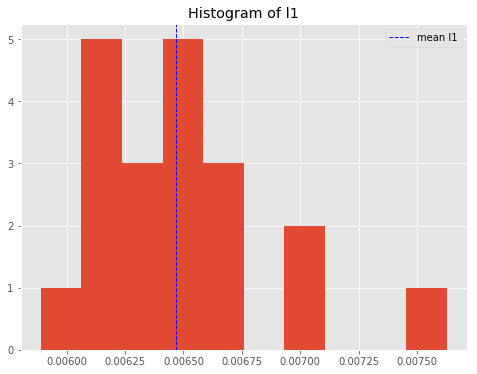

Average value (Median) is 0.006435
Std is 0.0004004


In [7]:
df = research.load_results(use_alias=True)
draw_histogram(df, 'test/l1', 100)